# Logistic Falkon model test
tutorial for the Logistic model

In [2]:
%matplotlib inline
import numpy as np
import time
from sklearn import datasets, model_selection
import torch
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

import falkon

from scipy.stats import chi2
from plot_utils import plot_one_t


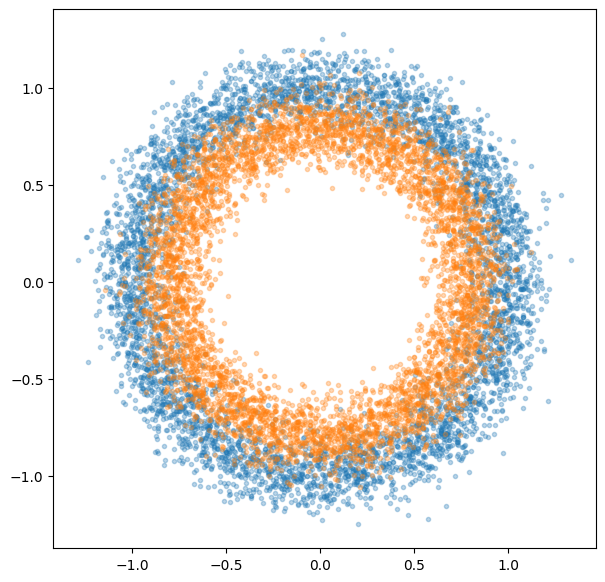

In [3]:
X, Y = datasets.make_circles(
    n_samples=10_000, shuffle=False, noise=0.1, random_state=122)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[Y == 0,0], X[Y == 0,1], alpha=0.3, marker='.')
_ = ax.scatter(X[Y == 1,0], X[Y == 1,1], alpha=0.3, marker='.')

In [4]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, test_size=0.2, random_state=10, shuffle=True)

In [5]:
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)
Y_train = torch.from_numpy(Y_train).to(dtype=torch.float32).reshape(-1, 1)
Y_test = torch.from_numpy(Y_test).to(dtype=torch.float32).reshape(-1, 1)

Y_train[Y_train == 0] = -1
Y_test[Y_test == 0] = -1

In [6]:
def binary_loss(true, pred):
    return torch.mean((true != torch.sign(pred)).to(torch.float32))



In [7]:
# We define some basic options to run on the CPU, and to disable keops
flk_opt = falkon.FalkonOptions(use_cpu=False, keops_active="no")
flk_kernel = falkon.kernels.GaussianKernel(1, opt=flk_opt)
flk = falkon.Falkon(kernel=flk_kernel, penalty=1e-7, M=1000, options=flk_opt)

In [11]:
logflk_opt = falkon.FalkonOptions(use_cpu=False, keops_active="no")

logflk_kernel = falkon.kernels.GaussianKernel(1, opt=logflk_opt)
logloss = falkon.gsc_losses.LogisticLoss(logflk_kernel)

penalty_list = [1e-3, 1e-5, 1e-7, 1e-7, 1e-7]
iter_list = [4, 4, 4, 8, 1_000]

logflk = falkon.LogisticFalkon(
    kernel=logflk_kernel, penalty_list=penalty_list, iter_list=iter_list, M=1000, loss=logloss,
    error_fn=binary_loss, error_every=1, options=logflk_opt)


In [12]:
%%time
flk.fit(X_train, Y_train)

CPU times: user 3.84 s, sys: 222 ms, total: 4.06 s
Wall time: 237 ms


Falkon(M=1000, center_selection=<falkon.center_selection.UniformSelector object at 0x7fcd84102c10>, kernel=GaussianKernel(sigma=Parameter containing:
tensor([1.], dtype=torch.float64)), options=FalkonOptions(keops_acc_dtype='auto', keops_sum_scheme='auto', keops_active='no', keops_memory_slack=0.7, chol_force_in_core=False, chol_force_ooc=False, chol_par_blk_multiplier=2, pc_epsilon_32=1e-05, pc_epsilon_64=1e-13, cpu_preconditioner=False, cg_epsilon_32=1e-07, cg_epsilon_64=1e-15, cg_tolerance=1e-07, cg_full_gradient_every=10, cg_differential_convergence=False, debug=False, use_cpu=False, max_gpu_mem=inf, max_cpu_mem=inf, compute_arch_speed=False, no_single_kernel=True, min_cuda_pc_size_32=10000, min_cuda_pc_size_64=30000, min_cuda_iter_size_32=300000000, min_cuda_iter_size_64=900000000, never_store_kernel=False, store_kernel_d_threshold=1200, num_fmm_streams=2, memory_slack=0.9), penalty=1e-07)

In [14]:
%%time
logflk.fit(X_train, Y_train)

Iteration 0 - penalty 1.000000e-03 - sub-iterations 4
Iteration   0 - Elapsed 0.05s - training loss 0.4697 - training error 0.1544 
Iteration 1 - penalty 1.000000e-05 - sub-iterations 4
Iteration   1 - Elapsed 0.12s - training loss 0.3774 - training error 0.1548 
Iteration 2 - penalty 1.000000e-07 - sub-iterations 4
Iteration   2 - Elapsed 0.18s - training loss 0.3577 - training error 0.1538 
Iteration 3 - penalty 1.000000e-07 - sub-iterations 8
Iteration   3 - Elapsed 0.25s - training loss 0.3554 - training error 0.1532 
Iteration 4 - penalty 1.000000e-07 - sub-iterations 1000
Iteration   4 - Elapsed 6.17s - training loss 0.3553 - training error 0.1531 
CPU times: user 13.3 s, sys: 844 ms, total: 14.2 s
Wall time: 6.19 s


LogisticFalkon(M=1000, center_selection=<falkon.center_selection.UniformSelector object at 0x7fce41a0b370>, error_fn=<function binary_loss at 0x7fcd840ff820>, iter_list=[4, 4, 4, 8, 1000], kernel=GaussianKernel(sigma=Parameter containing:
tensor([1.], dtype=torch.float64)), loss=LogisticLoss(kernel=GaussianKernel(sigma=Parameter containing:
tensor([1.], dtype=torch.float64))), options=FalkonOptions(keops_acc_dtype='auto', keops_sum_scheme='auto', keops_active='no', keops_memory_slack=0.7, chol_force_in_core=False, chol_force_ooc=False, chol_par_blk_multiplier=2, pc_epsilon_32=1e-05, pc_epsilon_64=1e-13, cpu_preconditioner=False, cg_epsilon_32=1e-07, cg_epsilon_64=1e-15, cg_tolerance=1e-07, cg_full_gradient_every=10, cg_differential_convergence=False, debug=False, use_cpu=False, max_gpu_mem=inf, max_cpu_mem=inf, compute_arch_speed=False, no_single_kernel=True, min_cuda_pc_size_32=10000, min_cuda_pc_size_64=30000, min_cuda_iter_size_32=300000000, min_cuda_iter_size_64=900000000, never_store_kernel=False, store_kernel_d_threshold=1200, num_fmm_streams=2, memory_slack=0.9), penalty_list=[0.001, 1e-05, 1e-07, 1e-07, 1e-07])

In [15]:
flk_pred = flk.predict(X_test)
flk_err = binary_loss(Y_test, flk_pred)

logflk_pred = logflk.predict(X_test)
logflk_err = binary_loss(Y_test, logflk_pred)

print("Falkon model          -- Error: %.2f%%" % (flk_err * 100))
print("Logistic Falkon model -- Error: %.2f%%" % (logflk_err * 100))

Falkon model          -- Error: 17.00%
Logistic Falkon model -- Error: 16.95%


In [16]:
def plot_predictions(preds, ax):
    ax.scatter(X_test[((Y_test == -1) & (preds.sign() == Y_test)).reshape(-1), 0],
               X_test[((Y_test == -1) & (preds.sign() == Y_test)).reshape(-1), 1],
               alpha=0.3, marker='.', color='b', label="correct cls 0")
    ax.scatter(X_test[((Y_test == 1) & (preds.sign() == Y_test)).reshape(-1),0],
               X_test[((Y_test == 1) & (preds.sign() == Y_test)).reshape(-1),1],
               alpha=0.3, marker='.', color='r', label="correct cls 1")

    ax.scatter(X_test[((Y_test == -1) & (preds.sign() != Y_test)).reshape(-1), 0],
               X_test[((Y_test == -1) & (preds.sign() != Y_test)).reshape(-1), 1],
               alpha=0.5, marker='x', color='b', label="wrong cls 0")
    ax.scatter(X_test[((Y_test == 1) & (preds.sign() != Y_test)).reshape(-1),0],
               X_test[((Y_test == 1) & (preds.sign() != Y_test)).reshape(-1),1],
               alpha=0.5, marker='x', color='r', label="wrong cls 1")



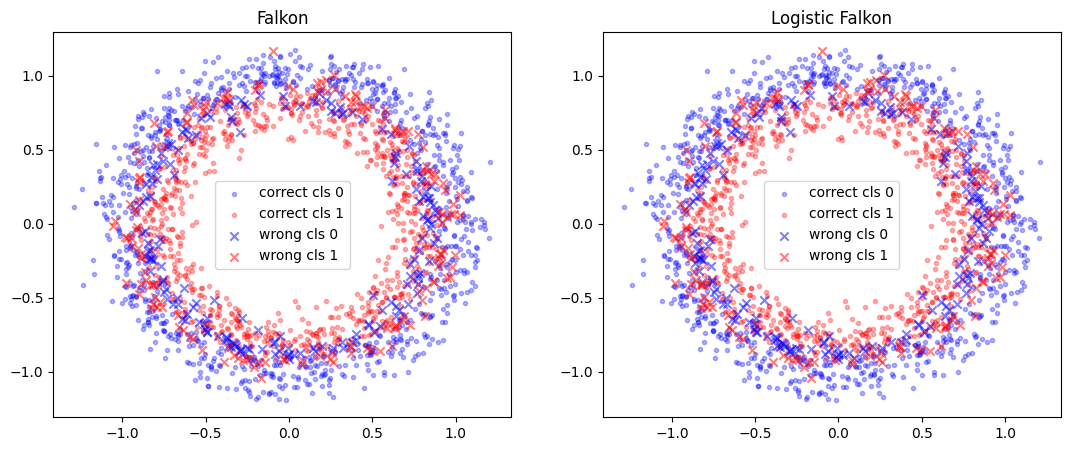

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
plot_predictions(flk_pred, ax[0])
ax[0].set_title("Falkon")
ax[0].legend(loc='best')

plot_predictions(logflk_pred, ax[1])
ax[1].set_title("Logistic Falkon")
ax[1].legend(loc='best')

# 1D try

In [4]:
# Statistics                                                                                                                                                   
N_REF      = 200000
N_BKG      = 2000
N_SIG      = 0  
SIG_LOC    = 6.4
SIG_STD    = 0.16
# Samples weights N_D/N_R
N_R        = N_REF
N_D        = N_BKG


In [5]:
# poisson fluctuate the number of events in each sample
N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())

# the reference rate will not have nuisance parameters
feature_ref_dist = torch.distributions.Exponential(rate=1)

# the data rate will have nuisance parameters   
feature_bkg_dist = torch.distributions.Exponential(rate=1)
feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)

feature_ref  = feature_ref_dist.sample((N_REF,1))
feature_data = torch.cat(
    (
        feature_bkg_dist.sample((N_bkg_p, 1)),
        feature_sig_dist.sample((N_sig_p, 1))
    )
)

feature = torch.cat((feature_ref, feature_data), dim=0)

target_ref  = torch.zeros((N_REF, 1))
target_data = torch.ones((N_bkg_p + N_sig_p, 1))

target = torch.cat((target_ref, target_data), dim=0)
print("target shape",target.shape)

weights_ref  = torch.ones((N_REF, 1)) * (N_D / N_R)
weights_data = torch.ones((N_bkg_p + N_sig_p, 1))

weights = torch.cat((weights_ref, weights_data), dim=0)

# concatenate the weights to the target
# target = torch.cat((target, weights), dim=1)

target shape torch.Size([201944, 1])


In [6]:
flk_opt = falkon.FalkonOptions(use_cpu=False, keops_active="no")
flk_kernel = falkon.kernels.GaussianKernel(1, opt=flk_opt)

logflk_opt = falkon.FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=False, debug = False)
logflk_kernel = falkon.kernels.GaussianKernel(sigma=2.3,  opt=logflk_opt)
logloss = falkon.gsc_losses.WeightedCrossEntropyLoss(logflk_kernel, neg_weight = N_D/N_R)

penalty_list = [1e-7, 1e-8, 1e-10]
iter_list = [10_000, 10_000, 10_000]

config = {
    "kernel"       : logflk_kernel,
    "M"            : 4000,
    "penalty_list" : [1e-10],
    "iter_list"    : [10_000],
    "options"      : logflk_opt,
    "seed"         : None,
    "loss"         : logloss,
}

logflk = falkon.LogisticFalkon(**config)


In [7]:
logflk.fit(feature, target)
ref_pred, data_pred = logflk.predict(feature_ref), logflk.predict(feature_data)
diff = N_D/N_R *torch.sum(1 - torch.exp(ref_pred))
t = 2 * (diff + torch.sum(data_pred).item()).item()
print(t)

Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
7.865814208984375


!! one single training since one single dataset is available

In [8]:
%%time
logflk.fit(feature, target)
ref_pred, data_pred = logflk.predict(feature_ref), logflk.predict(feature_data)
diff = N_D/N_R *torch.sum(1 - torch.exp(ref_pred))
t = 2 * (diff + torch.sum(data_pred).item()).item()
print(t)

Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
8.521308898925781
CPU times: user 11min 8s, sys: 21.9 s, total: 11min 29s
Wall time: 38.4 s


# 1D function

In [3]:
def learn_t(sigma, M, l, seed):
    
    N_REF      = 200_000
    N_BKG      = 2_000
    N_SIG      = 0
    SIG_LOC    = 6.4
    SIG_STD    = 0.16
    # poisson fluctuate the number of events in each sample
    # torch.manual_seed(seed)
    N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
    N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())

    # the reference rate will not have nuisance parameters
    feature_ref_dist = torch.distributions.Exponential(rate=1)

    # the data rate will have nuisance parameters   
    feature_bkg_dist = torch.distributions.Exponential(rate=1)
    feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)

    feature_ref  = feature_ref_dist.sample((N_REF,1))
    feature_data = torch.cat(
        (
            feature_bkg_dist.sample((N_bkg_p, 1)),
            feature_sig_dist.sample((N_sig_p, 1))
        )
    )
    
    # feature_ref  = feature_ref / torch.max(feature_ref)
    # feature_data = feature_data / torch.max(feature_data)
    feature = torch.cat((feature_ref, feature_data), dim=0)
    
    target_ref  = torch.zeros((N_REF, 1))
    target_data = torch.ones((N_bkg_p + N_sig_p, 1))

    target = torch.cat((target_ref, target_data), dim=0)
    print("target shape",target.shape)
    
    logflk_opt = falkon.FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=False, debug = False)
    logflk_kernel = falkon.kernels.GaussianKernel(sigma=sigma,  opt=logflk_opt)
    logloss = falkon.gsc_losses.WeightedCrossEntropyLoss(logflk_kernel, neg_weight = N_BKG/N_REF)

    config = {
        "kernel"       : logflk_kernel,
        "M"            : M,
        "penalty_list" : [l],
        "iter_list"    : [100_000],
        "options"      : logflk_opt,
        "seed"         : None,
        "loss"         : logloss,
    }

    logflk = falkon.LogisticFalkon(**config)
    logflk.fit(feature, target)
    ref_pred, data_pred = logflk.predict(feature_ref), logflk.predict(feature_data)
    diff = N_BKG/N_REF *torch.sum(1 - torch.exp(ref_pred))
    t = 2 * (diff + torch.sum(data_pred).item()).item()
    
    return t
    

In [4]:
l=1e-7
print(str(l))

1e-07


target shape torch.Size([202025, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202015, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202027, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([201983, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([201982, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([201983, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202051, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202023, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202014, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202015, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202062, 1])
Ite

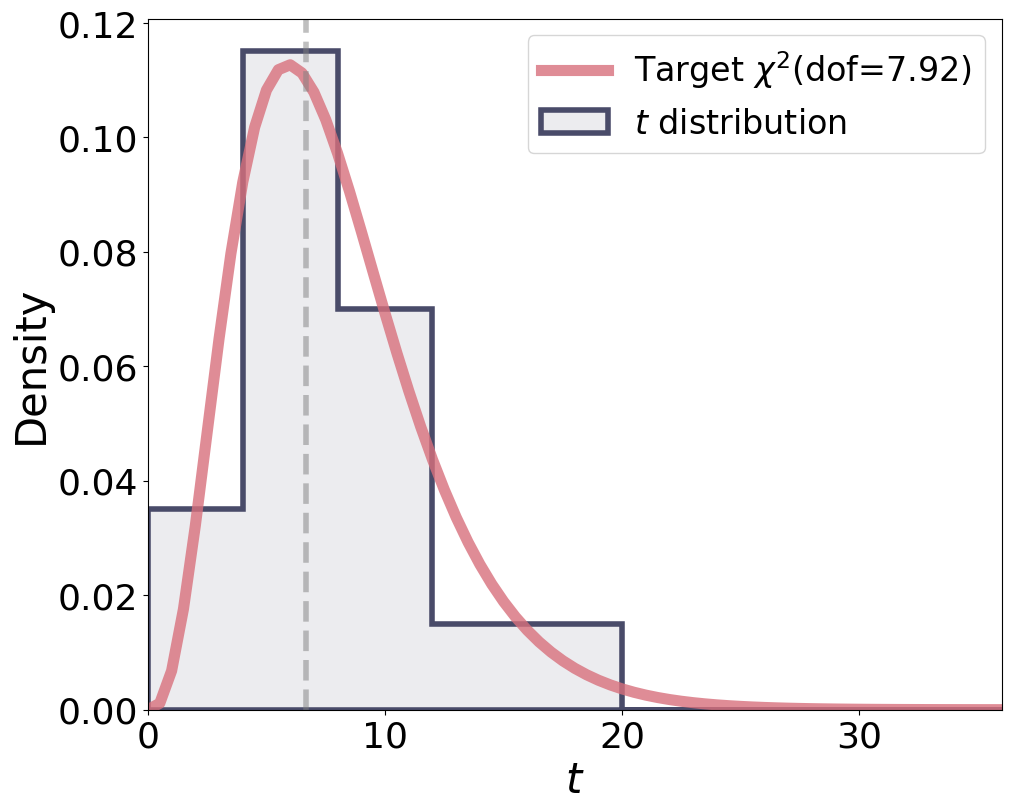

In [5]:
t_list=[]
toy=50
for _ in range(toy):
    t = learn_t(sigma=2.3, M=3000, l=1e-8, seed=time.time())
    t_list.append(t)
# bin = np.arange(0,20,4)
# plt.hist(t_list, bin)

df_fit, loc, scale = chi2.fit(t_list, floc=0, fscale=1)
print(df_fit)

t_ref_bins  = np.arange(0, 40, 4)
xgrid_ref   = np.arange(0, 40, 0.5)

ref_chi2 = chi2(df=df_fit)

plot_one_t(
    t_distribution  = t_list,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (10, 8),
    fontsize        = 30,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%.2f)"%(df_fit),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    # plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = False,
    wclip           = 2.6,
)


In [6]:
toys   = 30
M_list = [500, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000]
l_list = [1e-9, 1e-8, 1e-7]
sigma  = 2.3
t_list = []

for l in l_list:
    t_M_list = []
    for M in M_list:
        t_list_tmp = []
        for toy in range(toys):
            t = learn_t(sigma=sigma, M=M, l=l, seed=time.time())
            t_list_tmp.append(t)

        t_M_list.append(t_list_tmp)
        del t_list_tmp
    t_list.append(t_M_list)
    del t_M_list
    
    
        
# t_M_list_8 = []
# for M in M_list:
#     t_list_tmp = []
#     for toy in range(toys):
#         t = learn_t(sigma=sigma, M=M, l=l_list[1], seed=time.time())
#         t_list_tmp.append(t)

#     t_M_list_8.append(t_list_tmp)
#     del t_list_tmp
    

target shape torch.Size([202087, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([202036, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([202052, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([202087, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([202039, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([201914, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([202035, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([201990, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([201944, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([202015, 1])
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100000
target shape torch.Size([202001, 1])
Ite

In [12]:
toys   = 30
M_list = [500, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000]
l_list = [1e-10]
sigma  = 2.3

for l in l_list:
    t_M_list = []
    for M in M_list:
        t_list_tmp = []
        for toy in range(toys):
            t = learn_t(sigma=sigma, M=M, l=l, seed=time.time())
            t_list_tmp.append(t)

        t_M_list.append(t_list_tmp)
        del t_list_tmp
    t_list.append(t_M_list)
    del t_M_list
    
    
        
# t_M_list_8 = []
# for M in M_list:
#     t_list_tmp = []
#     for toy in range(toys):
#         t = learn_t(sigma=sigma, M=M, l=l_list[1], seed=time.time())
#         t_list_tmp.append(t)

#     t_M_list_8.append(t_list_tmp)
#     del t_list_tmp
    

target shape torch.Size([202002, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000


target shape torch.Size([201999, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([201958, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([202002, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([201961, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([201976, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([201983, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([201987, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([201998, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([202033, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([202010, 1])
Iteration 0 - penalty 1.000000e-06 - sub-iterations 100000
target shape torch.Size([201978, 1])
Ite

KeyboardInterrupt: 

In [14]:
len(t_list)

4

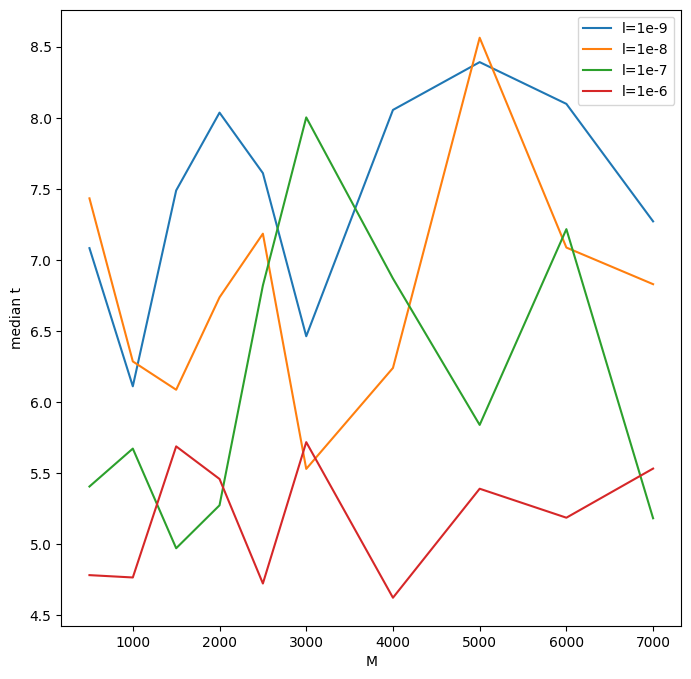

In [15]:
t_median9 = [np.median(t_list[0][i]) for i in range(len(t_list[0])) ]
t_median8 = [np.median(t_list[1][i]) for i in range(len(t_list[1])) ]
t_median7 = [np.median(t_list[2][i]) for i in range(len(t_list[2])) ]
t_median6 = [np.median(t_list[3][i]) for i in range(len(t_list[3])) ]
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(M_list,t_median9, label="l=1e-9")
ax.plot(M_list,t_median8, label="l=1e-8")
ax.plot(M_list,t_median7, label="l=1e-7")
ax.plot(M_list,t_median6, label="l=1e-6")
ax.set_xlabel('M')
ax.set_ylabel('median t')
ax.legend()
